In [2]:
device = 'cpu'


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
from tqdm import notebook as tqdm
from ema_pytorch import EMA


In [37]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Resize((64, 64)),
])

train_dataset = torchvision.datasets.QMNIST('data', train=True, download=True, transform=transforms)
# test_dataset = torchvision.datasets.QMNIST('data', train=False, download=True, transform=transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, persistent_workers=True)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training with {len(train_dataset)} samples")
# print(f"Testing with {len(test_dataset)} samples")


Training with 60000 samples


In [74]:
class Generator(nn.Module):
    """DCGAN Generator
    Based off of https://arxiv.org/abs/1511.06434
    """

    def __init__(
        self,
        depth: int,
        channels: int = 3,
        latent: int = 100,
    ) -> None:
        super(Generator, self).__init__()
        self.depth = depth
        self.channels = channels
        self.latent = latent

        self.layers = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x).view(x.size(0), self.channels, 28, 28)


class Discriminator(nn.Module):
    """DCGAN Discriminator"""

    def __init__(
        self,
        depth: int,
        channels: int = 3,
    ) -> None:
        super(Discriminator, self).__init__()
        self.depth = depth
        self.channels = channels

        self.layers = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.view(x.size(0), -1)
        return self.layers(x)

    def grad_penalty(self, real: torch.Tensor, fake: torch.Tensor) -> torch.Tensor:
        alpha = torch.rand(real.size(0), 1, 1, 1).to(real.device)
        interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        d_interpolates = self(interpolates)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones(d_interpolates.size()).to(real.device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gp

generator = Generator(depth=8, channels=1).to(device)
discriminator = Discriminator(depth=4, channels=1).to(device)


In [75]:
print(f"Generator has {sum(p.numel() for p in generator.parameters() if p.requires_grad):,} parameters")
print(f"Discriminator has {sum(p.numel() for p in discriminator.parameters() if p.requires_grad):,} parameters")


Generator has 559,632 parameters
Discriminator has 533,505 parameters


In [76]:
optim_g = optim.Adam(generator.parameters(), lr=1e-3)
optim_d = optim.Adam(discriminator.parameters(), lr=1e-3)

ema_d = EMA(discriminator, beta=0.9)
ema_g = EMA(generator, beta=0.9)


In [77]:
generator.train()
discriminator.train()

with tqdm.trange(10) as tepoch:
    for epoch in tepoch:
        with tqdm.tqdm(train_loader) as tbatch:
            for real, y in train_loader:
                noise = torch.randn(real.size(0), 100, device=device)
                
                # Train Discriminator
                optim_d.zero_grad()
                fake = generator(noise)
                real_score = discriminator(real)
                fake_score = discriminator(fake)
                
                loss_d = fake_score.mean() - real_score.mean() + discriminator.grad_penalty(real, fake) * 10 + 0.001 * (real_score ** 2).mean()
                
                loss_d.backward()
                optim_d.step()
                
                # ema_d.update()

                # Train generator
                if tbatch.n % 4 == 0:
                    optim_g.zero_grad()
                    noise = torch.randn(real.size(0), 100, device=device)
                    loss_g = -discriminator(generator(noise)).mean()
                    loss_g.backward()
                    optim_g.step()
                    
                    ema_g.update()
                    
                # Update progress bars
                tbatch.set_postfix_str(f"Loss D: {loss_d.item():.3f}, Loss G: {loss_g.item():.3f}, Sliced W: {real_score.mean() - fake_score.mean():.3f}")
                tbatch.update()
                
        tepoch.set_postfix(
            {
                "Loss D": loss_d.item(),
                "Loss G": loss_g.item(),
            }
        )
        tepoch.update()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 0/938 [00:00<?, ?it/s]

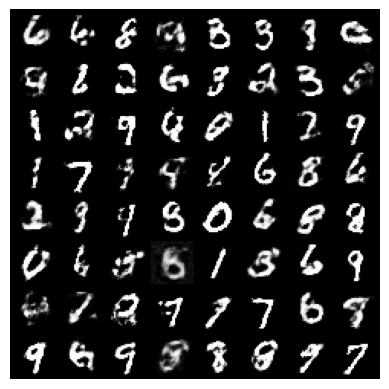

In [78]:
with torch.no_grad():
    noise = torch.randn(64, 100, device=device)
    fake = generator(noise)
    
    grid = torchvision.utils.make_grid(fake, nrow=8)
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


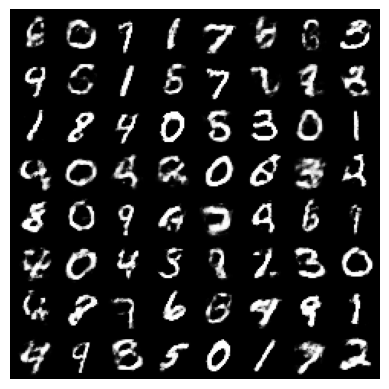

In [ ]:
with torch.no_grad():
    noise = torch.randn(64, 100, device=device)
    fake = generator(noise)
    
    grid = torchvision.utils.make_grid(fake, nrow=8)
    
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [46]:
# # make a new folder in the current directory called "generated" to save the images
# import os
# import time

# if not os.path.exists("generated"):
#     os.makedirs("generated")
    

# c_time = time.strftime("%Y/%m/%d-%H:%M:%S")

# if not os.path.exists(f"generated/{c_time}"):
#     os.makedirs(f"generated/{c_time}")


# # generate 100 images and save them in the "generated" folder
# for i in range(100):
#     noise = torch.randn(1, 100, device=device)
#     img = generator(noise).squeeze().detach().cpu().numpy()
#     plt.imsave(f"generated/{c_time}/{i}.png", img, cmap='gray')
